# GeMpy

In [1]:
import sys
sys.path.append("../")
import gempy as gp

%matplotlib inline
import pymc
import numpy as np
import math

In [2]:
geo_data = gp.read_pickle("../Tutorial/BasicFault.pickle")
geo_data.n_faults = 1

In [3]:
geo_data.interfaces.head()

,X,Y,Z,formation,series,order_series,isFault
0,800.0,1000.0,-1600.0,MainFault,fault,1,True
1,1200.0,1000.0,-400.0,MainFault,fault,1,True
2,1100.0,1000.0,-700.0,MainFault,fault,1,True
3,900.0,1000.0,-1300.0,MainFault,fault,1,True
4,1000.0,1000.0,-1000.0,MainFault,fault,1,True


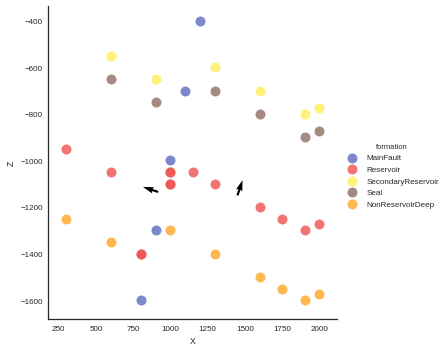

In [4]:
geo_data.geo_data_type = 'whatever'
gp.plot_data(geo_data, direction='y')

In [5]:
# stdev for x,y,z interface coordinates
geo_data.interfaces['X_std'] = None
geo_data.interfaces['Y_std'] = None
geo_data.interfaces['Z_std'] = 100
geo_data.interfaces['dist_type'] = "Normal" # should be initially None
geo_data.interfaces['X_dist'] = None
geo_data.interfaces['Y_dist'] = None
geo_data.interfaces['Z_dist'] = None

#geo_data.foliations['X_std'] = None
#geo_data.foliations['Y_std'] = 0
#geo_data.foliations['Z_std'] = 0

In [6]:
geo_data.interfaces["Z_std"] = 500

In [7]:
geo_data.interfaces.head()

,X,Y,Z,formation,series,order_series,isFault,X_std,Y_std,Z_std,dist_type,X_dist,Y_dist,Z_dist
0,800.0,1000.0,-1600.0,MainFault,fault,1,True,None,None,500,Normal,None,None,None
1,1200.0,1000.0,-400.0,MainFault,fault,1,True,None,None,500,Normal,None,None,None
2,1100.0,1000.0,-700.0,MainFault,fault,1,True,None,None,500,Normal,None,None,None
3,900.0,1000.0,-1300.0,MainFault,fault,1,True,None,None,500,Normal,None,None,None
4,1000.0,1000.0,-1000.0,MainFault,fault,1,True,None,None,500,Normal,None,None,None


In [8]:
interp_data = gp.InterpolatorInput(geo_data, 
                                   u_grade = [3, 3],
                                   compile_theano=True)

float32
[2, 2]


In [10]:
sol = gp.compute_model(interp_data)

[3, 3]


adding dataframe columns for uncertainty analysis

### Create pymc.Distribution objects for each stochastic value and put into df

In [11]:
Z_rest = pymc.Normal('Z_unc_rest',  interp_data.interpolator.pandas_rest_layer_points['Z'].as_matrix().astype('float32'),
           1./interp_data.interpolator.pandas_rest_layer_points['Z_std'].as_matrix().astype('float32'))

Z_ref = pymc.Normal('Z_unc_ref',  interp_data.interpolator.pandas_ref_layer_points['Z'].as_matrix().astype('float32'),
           1./interp_data.interpolator.pandas_ref_layer_points['Z_std'].as_matrix().astype('float32'))


### Create pymc.Model

In [14]:

i = interp_data.get_input_data()

@pymc.deterministic
def gempy_model(value=0, input_ =  i, Z_rest_m = Z_rest, Z_ref_m = Z_ref):
          #xp = X_priors, yp = Y_priors, zp = Z_priors, ref = data_ref):
    

    Z_ref_m_rep = np.apply_over_axes(lambda x,y:
                    np.repeat(x, interp_data.interpolator.len_interfaces - 1),
                    Z_ref_m, axes = [0])
   
    input_[4][:, 2] = Z_ref_m_rep
    input_[5][:, 2] = Z_rest_m
    
    sol, pot = interp_data.th_fn(*input_)
    print(sol[0,0,:])
    # return solution
    return sol

[3, 3]
[ 0.  0.  0. ...,  0.  0.  0.]


In [15]:
# set number of iterations
iterations = 10

In [16]:

# set model
pymc_model = pymc.Model(Z_ref, Z_rest, gempy_model)

### MCFS

In [ ]:
MCFS_RUN = pymc.MCMC(pymc_model)
MCFS_RUN.sample(iter=iterations)

[ 2.  2.  2. ...,  2.  2.  2.]
 [-------          20%                  ] 2 of 10 complete in 2.3 sec[ 0.  0.  0. ...,  2.  2.  2.]
 [-----------      30%                  ] 3 of 10 complete in 4.6 sec[ 2.  2.  2. ...,  4.  4.  4.]
 [---------------  40%                  ] 4 of 10 complete in 6.8 sec[ 2.  2.  2. ...,  5.  5.  5.]
 [-----------------50%                  ] 5 of 10 complete in 9.0 sec

In [27]:
import matplotlib.pyplot as plt

In [59]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [28]:
def p(i):
    ax.imshow(MCFS_RUN.trace("gempy_model", chain=-1)[i][0, 0, :].reshape(50,50,50)[:,24,:].T, origin="lower")

NameError: name 'interact' is not defined

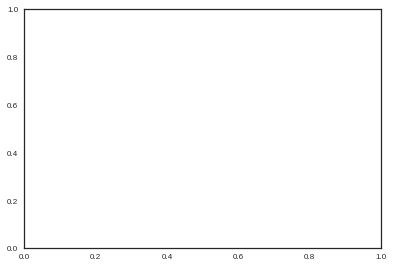

In [29]:
fig, ax = plt.subplots()
interact(p, i=widgets.IntSlider(min=0, max=9, step=1, value=0));

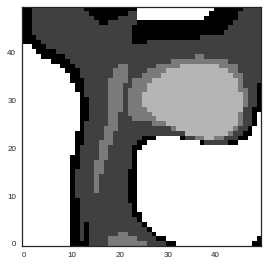

In [32]:
plt.imshow(MCFS_RUN.trace("gempy_model", chain=-1)[3][0, 0, :].reshape(50,50,50)[:,24,:].T, origin="lower")